In [48]:
%reload_ext autoreload
%autoreload 2

In [25]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
import json
from graph_utils import pickle_model,load_pickle_model

In [3]:
from sklearn.cluster import MiniBatchKMeans, OPTICS
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

# Table of contents
 - [Preprocessing](#Preprocessing)
 - [Pipelines](#Pipelines)
 - [Model Training](#models)
    - [Logistic Regression](#log)
    - [K Nearest Neighbors](#knn)
    - [Random Forest](#rfc)
    - [XGBoost](#xgb)
    - [LightGBM](#lgbm)
 - [Model Analysis](#analysis1) 
    - [Model Comparisons](#compare)
    - [Examining Feature Importance](#featImp)
 - [Stacking Classifier](#stackClf)
 - [For Business Stakeholders](#business)

# <a name="Preprocessing">Preprocessing</a>

In [ ]:
RANDOM_SEED = 1337
MODEL_PICKLE_PATH = 'ModelPickles/'

In [ ]:
full_data = pd.read_csv('Dataset/clean_data.csv',index_col='customerID')
churn = full_data['Churn'].copy()
full_data = full_data.drop('Churn',axis=1)

In [6]:
#Separate data for training and testing with 80% for training and 20% testing
#Uses our preselected random seed to results are reproducible 
raw_x_train, raw_x_test, y_train, y_test = train_test_split(
    full_data,
    churn,
    test_size=0.2,
    random_state=RANDOM_SEED
)

In [7]:
# These are the internet related services we found during EDA
serv_cols = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
             'TechSupport','StreamingTV', 'StreamingMovies']

We will use several different algorithms then compare their performance afterwards to determine which is the best to use. The algorithm we will use are: 
- Logistic Regression
- K Nearest Neighbor Classifier
- Random Forest
- XGBoost
- LightGBM

For each model, the training process will be as follows:
 1. Determine basic parameters
 2. Conduct 5-Stratified-Folds to tune our hyperparameters 
    - 80% training, 20% validation
    - folds ensure same number of target class
 3. Pick the best model through highest mean AUROC of all folds
    - A solid argument can be made for optimizing hyperparameters using F1 scores or Average precision from PRAUC instead, due to the imbalanced target class and slightly higher importance of positive classes. 
    - However, the negative classes are still very important due to the fact that offering anti-churn promotions to customers who would have stayed also means lost profits. 
    - Furthermore, a 3:1 imbalance ratio is actually relatively tame, and would already be well compensated for by weighting the loss function in the algorithms which we will do. 
    - Lastly, we do not know the cost tradeoff necessary for counter-churn measures it would be better of to use a curve so we can change the decision threshold later on as the stakeholders see fit. 


After all is said an done, we will examine more business related KPI's such as lift and deploy our ML models. 

# <a name="Pipelines">Pipelines</a>

In [11]:
from pipeline_factory import PipelineFactory

In [12]:
pf = PipelineFactory(raw_x_train)

In [414]:
log_pipe = pf.create_pipe(
    counted_services=serv_cols, engineer=True,
    random_seed = RANDOM_SEED, normalize=True
)

log_x_train = log_pipe.fit_transform(raw_x_train)
log_x_test = log_pipe.transform(raw_x_test)

In [14]:
tree_pipe = pf.create_pipe(
    counted_services=serv_cols, engineer=True,
    random_seed = RANDOM_SEED, normalize=False
)

tree_x_train = tree_pipe.fit_transform(raw_x_train)
tree_x_test = tree_pipe.transform(raw_x_test)

# <a name="models">Model Training</a>

## <a name="log">Logistic Regression</a>

In [15]:
from sklearn.linear_model import LogisticRegression
from graph_utils import graph_cv_results

In [16]:
from sklearn.metrics import ( 
    roc_auc_score,
    RocCurveDisplay,
    ConfusionMatrixDisplay,
) 
from sklearn.model_selection import GridSearchCV

In [415]:
log_reg = LogisticRegression(
    random_state=RANDOM_SEED,
    class_weight='balanced',
    solver='saga',
    penalty='elasticnet',
    max_iter=5000
)

In [593]:
log_grid_cv = GridSearchCV(
    log_reg,
    param_grid={
        'l1_ratio':[0,0.2,0.4,0.6,0.8,1],
        'C':[1,10]
    },
    scoring='roc_auc',cv=5)
log_grid_cv.fit(log_x_train,y_train)

We can take a look at how the hyperparameters are affecting their scores. In the case for logistic regression, however, it seems like none of the hyperparameters are affecting the scores much. 

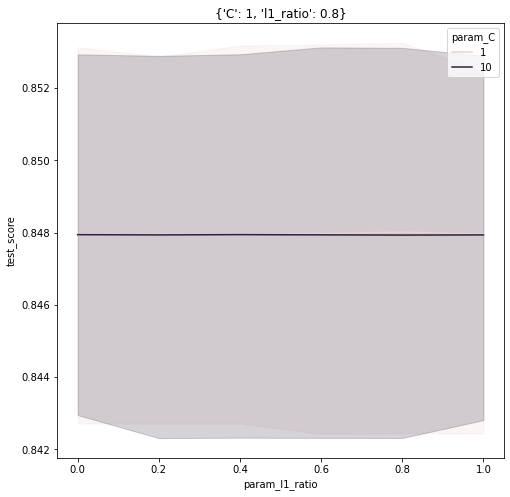

In [321]:
graph_cv_results(log_grid_cv,x='param_l1_ratio',hue='param_C')

In [199]:
pickle_model(log_reg,MODEL_PICKLE_PATH+'log_reg')

## <a name="knn">K Nearest Neighbors</a>

In [20]:
from sklearn.neighbors import KNeighborsClassifier

In [419]:
knn = KNeighborsClassifier()

In [594]:
knn_grid_cv = GridSearchCV(
    knn,
    {
        'n_neighbors':range(10,100,5),
        'weights':['uniform','distance']
    },
    scoring='roc_auc',cv=5)
knn_grid_cv.fit(log_x_train,y_train)

For K-Neighbors classifier, it seems like the diminishing returns for raising n_neighbors parameter starts to hit at around 60 something neighbors, with uniform weight clearly being the better option. 

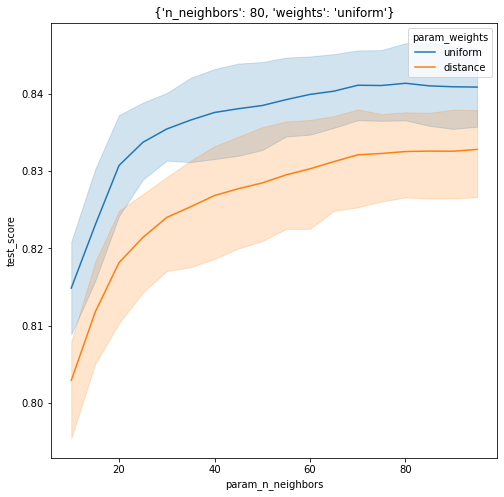

In [421]:
graph_cv_results(knn_grid_cv,x='param_n_neighbors',hue='param_weights')

In [423]:
pickle_model(knn_grid_cv,MODEL_PICKLE_PATH+'knn_grid_cv')

## <a name="rfc">Random Forest</a>

In [30]:
from sklearn.ensemble import RandomForestClassifier

In [31]:
rfc = RandomForestClassifier(random_state=RANDOM_SEED,class_weight='balanced')

In [595]:
rfc_grid_cv = GridSearchCV(
    rfc,
    {
        'n_estimators':range(80,120,10),
        'min_samples_split':range(6,10)
    },
    scoring='roc_auc',cv=5)
rfc_grid_cv.fit(tree_x_train,y_train)

The number of estimators seems to not affect the scores much for a random forest classifier, but it seems like a higher min_sample_split values does help

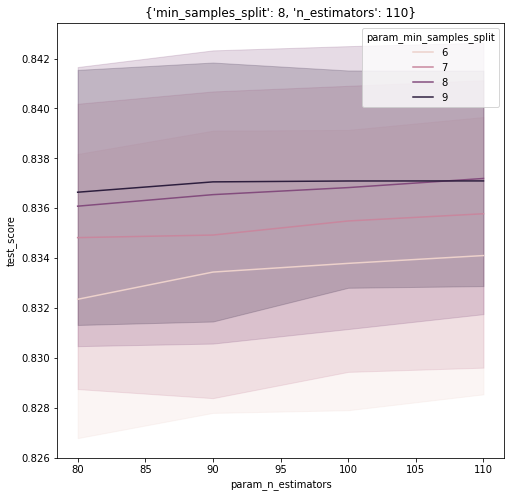

In [109]:
graph_cv_results(rfc_grid_cv,x='param_n_estimators',hue='param_min_samples_split')

In [125]:
pickle_model(rfc_grid_cv,MODEL_PICKLE_PATH+'rfc_grid_cv')

## <a name="xgb">XGBoost</a>

In [218]:
from xgboost import XGBClassifier

In [379]:
xgbClf = XGBClassifier(
    gamma=0,
    objective= 'binary:logistic',
    importance_type='gain',
    nthread=4,
    seed=RANDOM_SEED
)

In [596]:
xgb_grid_cv = GridSearchCV(
    xgbClf,
    param_grid={
        'learning_rate':[0.1,0.3],
        'n_estimators':[10,15,20],
        'min_child_weight':[1,2,3],
        'max_depth':[3,4,5,6],
        'scale_pos_weight':[1,np.bincount(y_train)[0]
                            /np.bincount(y_train)[1]],
        'colsample_bytree':[0.9,1],
        'colsample_bylevel':[0.9,1],
        'subsample':[0.9,1]
    },
    scoring='roc_auc',cv=5)
xgb_grid_cv.fit(tree_x_train,y_train)

XGBoost has way too many hyperparameters to be show in just a few graphs, but here is one of the more interesting hyperparameter tuning results. It seems like any depth higher than 4 starts to cause the model to overfit very quickly, hence a low depth paried with high number of estimators seems to work the best. 

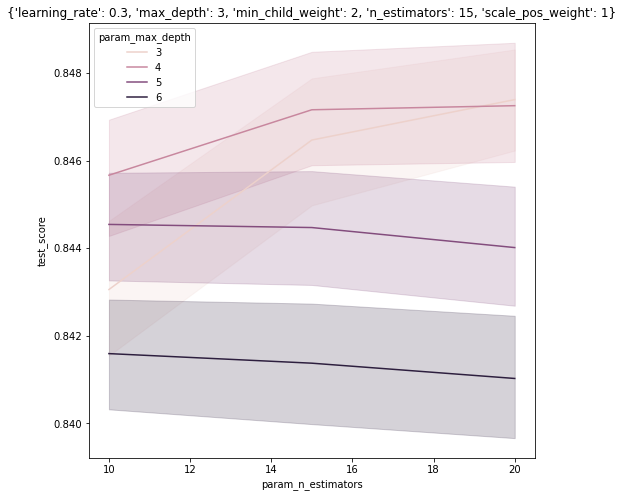

In [457]:
graph_cv_results(xgb_grid_cv,x='param_n_estimators',hue='param_max_depth')

In [391]:
pickle_model(xgb_grid_cv,MODEL_PICKLE_PATH+'xgb_grid_cv')

## <a name="lgbm">LightGBM</a>

In [150]:
from lightgbm import LGBMClassifier

In [642]:
lgbm = LGBMClassifier(
    objective= 'binary',
    class_weight='balanced',
    random_state=RANDOM_SEED
)

In [647]:
lgbm_grid_cv = GridSearchCV(
    lgbm,
    param_grid={
        'learning_rate':[0.1,0.3],
        'n_estimators':[15,20,25,30,35,40,45],
        'num_leaves':[5,8,10,15,20,25],
        'min_child_samples':[15,20,25],
        'subsample':[0.9,1]
    },
    scoring='roc_auc',cv=5)
lgbm_grid_cv.fit(tree_x_train,y_train)

Just like XGBoost, there are a lot more hyperparameters to tune and hence we'll only show the most interesting one. LightGBM seems to suffer the same problem where at a high number of leaves the model starts to overfit quickly. Furthermore, n_estimators seem to also cause models to overfit for high num leaves, but improve performance for num leaves. 

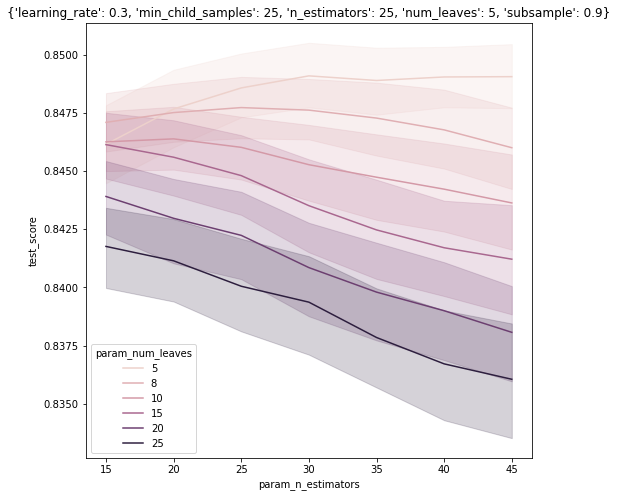

In [646]:
graph_cv_results(lgbm_grid_cv,x='param_n_estimators',hue='param_num_leaves')

In [649]:
pickle_model(lgbm_grid_cv,MODEL_PICKLE_PATH+'lgbm_grid_cv')

# <a name="analysis1">Model Analysis</a>

## <a name="compare">Model Comparisons</a>

In [739]:
from graph_utils import graph_estimator_auc, graph_estimator_cmat

From examining the AUROC scores below, we see that the best algorithms were Logistic Regression and LightGBM with relatively close scores, and Logistic Regression eeking out just a tiny bit. 

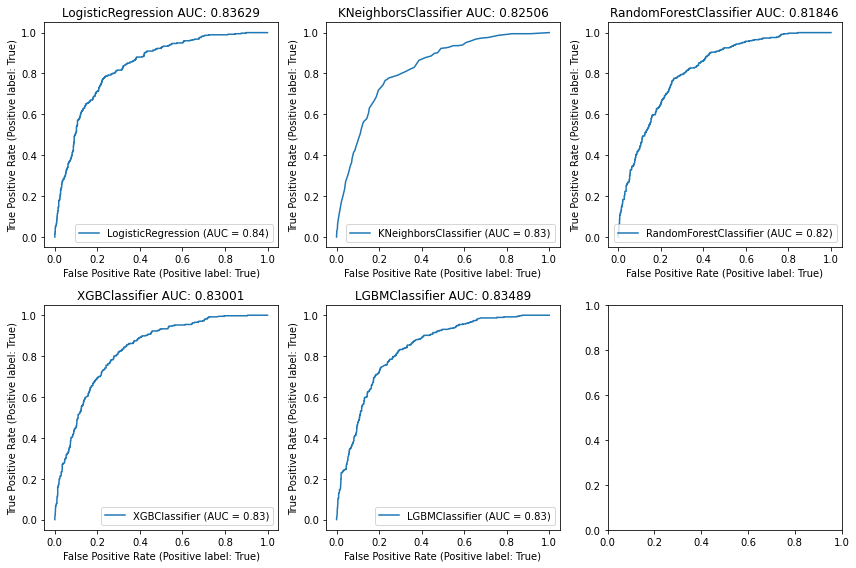

In [734]:
graph_estimator_auc(
    estimators=[log_grid_cv.best_estimator_,
                knn_grid_cv.best_estimator_,
                rfc_grid_cv.best_estimator_,
                xgb_grid_cv.best_estimator_,
                lgbm_grid_cv.best_estimator_],
    data_ls=[log_x_test,log_x_test,tree_x_test,tree_x_test,tree_x_test],
    y_test=y_test
)

## <a name="featImp">Examining Feature Importance</a>

In [699]:
from graph_utils import graph_feat_importance

We can also take a look at what features influenced the decisions of our models the most. Looking at logistic regression, it seems that it relies heavily upon our engineered KMeans labels to make its decisions, as the absolute value of their coefficients are really high. Furthermore, it relies heavily upon whether the customer subscribed to internet services. 

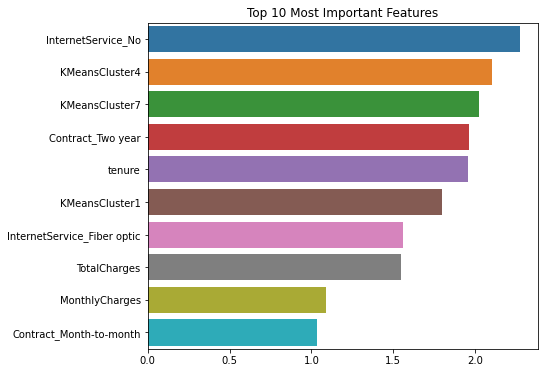

In [704]:
graph_feat_importance(abs(log_grid_cv.best_estimator_.coef_.reshape(-1)),log_pipe.get_feature_names_out())

LightGBM on the other hand, relies more on tenure and the charges to make its decision. However, one of the KMeans labels we engineered also seem to be one of its highest valued features. 

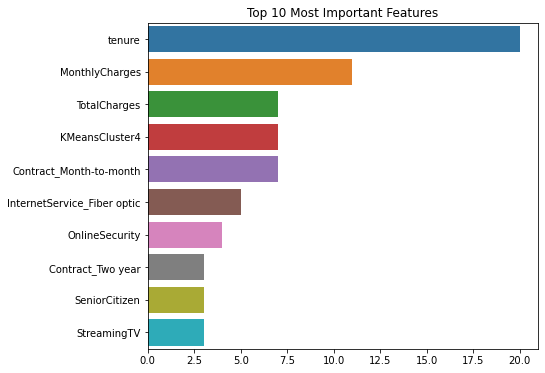

In [705]:
graph_feat_importance(lgbm_grid_cv.best_estimator_.feature_importances_,tree_pipe.get_feature_names_out())

# <a name="stackClf">Stacking Classifier</a>

In [221]:
from sklearn.ensemble import StackingClassifier

Lastly, we can combine all of our previous estimators with their best hyperparameters to create an ensemble model and see if it out performs our best estimator. 

In [217]:
stack_pipe = pf.create_pipe(
    counted_services=serv_cols, engineer=True,
    random_seed = RANDOM_SEED, normalize=True
)

stack_x_train = stack_pipe.fit_transform(raw_x_train)
stack_x_test = stack_pipe.transform(raw_x_test)

In [256]:
estimators = [
    ('log',LogisticRegression(**log_grid_cv.best_estimator_.get_params())),
    ('knn',KNeighborsClassifier(**knn_grid_cv.best_estimator_.get_params())),
    ('rfc',RandomForestClassifier(**rfc_grid_cv.best_estimator_.get_params())),
    ('xgb',XGBClassifier(**xgb_grid_cv.best_estimator_.get_params())),
    ('lgbm',LGBMClassifier(**lgbm_grid_cv.best_estimator_.get_params()))
]

In [286]:
# We'll forgo hyperparameter tuning as 
# it doesn't actually do much for log regression
final_estimator = LogisticRegression(
    random_state=RANDOM_SEED,
    class_weight='balanced',
    solver='saga',
    max_iter=5000
)

In [287]:
stack_clf = StackingClassifier(
    estimators=estimators,
    final_estimator=final_estimator
)
stack_clf.fit(stack_x_train,y_train)

In [ ]:
pickle_model(stack_clf,MODEL_PICKLE_PATH+'stack_clv')

It seems like our ensemble method does eek out a tiny better bit of performance than our logistic regression model. 

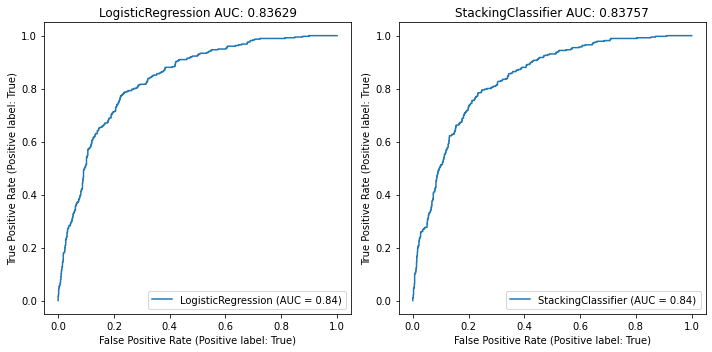

In [735]:
graph_estimator_auc(
    estimators=[log_grid_cv.best_estimator_,stack_clf],
    data_ls=[log_x_test,stack_x_test],
    y_test=y_test,figsize=(10,5)
)

Looking closer at the confusion matrix, we see that although our ensemble stacking classifier missed just one case of churned customer, it sees much better separation in the negative classes (where customers decided to stay)

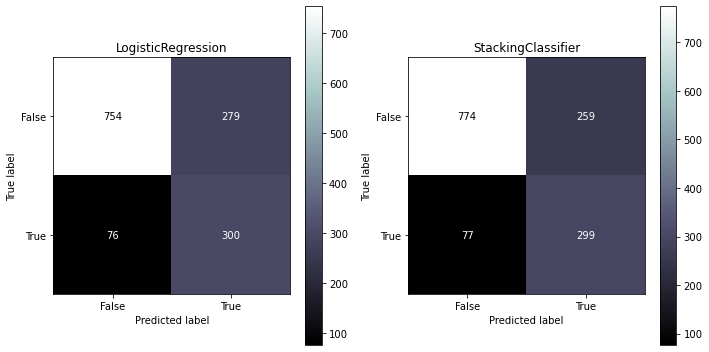

In [738]:
graph_estimator_cmat(
    estimators=[log_grid_cv.best_estimator_,stack_clf],
    data_ls=[log_x_test,stack_x_test],
    y_test=y_test,figsize=(10,5)
)

# <a name="business">Calculating Lift for Business Stakeholders</a>

In [753]:
from graph_utils import graph_lift

To translate our model performance to something that business stakeholders would be able to understand, we created a lift chart below. 
 - If we use our model to pick customers that will churn, our model can correctly predict 10.1 times more customers that will churn compared to randomly picking 10% of the customers without the model. 

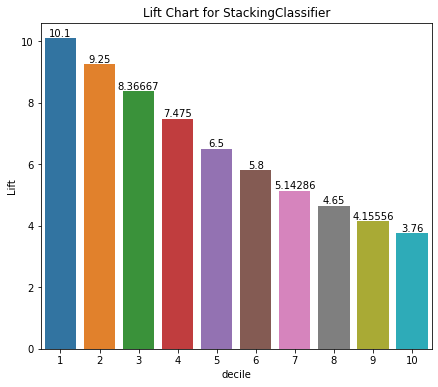

In [754]:
graph_lift(stack_clf,y_test,stack_x_test)